In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import glob
import pickle

# os.chdir("/content/drive/My Drive/app")

import gc
import copy

# ================================================

if not '..' in sys.path:
    sys.path = ['..', '.'] + sys.path

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler

from albumentations import Compose, OneOf, Blur, Flip, Rotate, HueSaturationValue, Normalize
from albumentations.pytorch import ToTensor

# from torch_utils import *
# from metrics import accuracy

# ================================================

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

# ================================================

PATH_TO_DATA = "./data/cifar-10-batches-py"

## **Data Loading.**

In [4]:
X_train0 = []
y_train0 = []

for fname in glob.glob(os.path.join(PATH_TO_DATA, 'data_batch_*')):
    with open(fname, 'rb') as fh:
        batch = pickle.load(fh, encoding='bytes')
        
    X_train0.append(batch[b'data'])
    y_train0 += batch[b'labels']
    
X_train0 = np.vstack(X_train0)
X_train0 = X_train0.reshape(-1, 3, 32, 32)
y_train0 = np.array(y_train0)
print('Training data shape: {0}x{1}'.format(*X_train0.shape))

# ================================================

with open(os.path.join(PATH_TO_DATA, 'test_batch'), 'rb') as fh:
    batch = pickle.load(fh, encoding='bytes')
    
    X_test0 = batch[b'data']
    X_test0 = X_test0.reshape(-1, 3, 32, 32)
    y_test0 = batch[b'labels']
    
print('Test data shape: {0}x{1}'.format(*X_test0.shape))

# ================================================
# Load images categories

with open(os.path.join(PATH_TO_DATA, 'batches.meta'), 'rb') as fh:
    categories_meta = pickle.load(fh, encoding='bytes')
    categories = [x.decode('UTF-8') for x in categories_meta[b'label_names']]
    
# ================================================
# Normalize dataset separately on each channel
    
X_mean = (X_train0.astype(np.float64)/255).mean(axis=(0, 2, 3))
X_std = (X_train0.astype(np.float64)/255).std(axis=(0, 2, 3))

Training data shape: 50000x3
Test data shape: 10000x3


In [5]:
val_part = 0.25
val_num = int(val_part*X_train0.shape[0])
tot_idxs = np.random.permutation(np.arange(X_train0.shape[0]))

val_idxs = tot_idxs[:val_num]
train_idxs = tot_idxs[val_num:]

## **Set up Pytorch**

In [6]:
assert torch.cuda.is_available()
GPU = torch.device('cuda: 0')

In [7]:
class Flattener(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, X):
        return X.view(X.shape[0], -1)

In [8]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, kernel_size=3):
        super().__init__()
        
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=False), 
            nn.BatchNorm2d(hidden_channels), 
            nn.ReLU(True), 
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernel_size, 
                      padding=(kernel_size - 1)//2, bias=False), 
            nn.BatchNorm2d(hidden_channels), 
            nn.ReLU(True), 
            nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=False), 
            nn.BatchNorm2d(out_channels)
        )
        
        if in_channels == out_channels:
            self.walkaround = nn.BatchNorm2d(in_channels)
        else:
            self.walkaround = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False), 
                nn.BatchNorm2d(out_channels)
            )
            
        self.relu_out = nn.ReLU(True)
        

    def forward(self, X):
        identity = self.walkaround(X)
        out = self.convblock(X)
        
        out += identity
        out = self.relu_out(out)
        
        return out

In [9]:
class TinyResNet(nn.Module):
    def __init__(self, res_blocks=1, res_kernel=3, downsampling='maxpool', 
                 start_channels=64, out_channels_mult=2, hid_channels_mult=1, 
                 drop_conv=None, drop_linear=None):
        super().__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(3, start_channels, kernel_size=1, bias=False), 
            nn.BatchNorm2d(start_channels), 
            nn.ReLU(True)
        )
        
        # ----------------
        
        cur_sz = 32
        cur_channels = start_channels
        ib = 1
        
        while cur_sz > 1:
            self.add_module(f'resblock{ib}', nn.Sequential(
                Bottleneck(cur_channels, int(cur_channels*out_channels_mult), 
                           int(cur_channels*hid_channels_mult), res_kernel), 
                *[
                    Bottleneck(int(cur_channels*out_channels_mult), 
                               int(cur_channels*out_channels_mult), 
                               int(cur_channels*out_channels_mult*hid_channels_mult), 
                               res_kernel) for ix in range(res_blocks - 1)
                ]
            ))
            cur_channels = int(cur_channels*out_channels_mult)
            
            # --------------------------------
            
            if downsampling == 'maxpool':
                self.add_module(f'downsample{ib}', nn.Sequential(
                    nn.MaxPool2d(kernel_size=2, stride=2), 
                    nn.BatchNorm2d(cur_channels), 
                    nn.ReLU(True)
                ))
            elif downsampling == 'avgpool':
                self.add_module(f'downsample{ib}', nn.Sequential(
                    nn.AvgPool2d(kernel_size=2, stride=2), 
                    nn.BatchNorm2d(cur_channels), 
                    nn.ReLU(True)
                ))
            elif downsampling == 'conv':
                self.add_module(f'downsample{ib}', nn.Sequential(
                    nn.Conv2d(cur_channels, cur_channels, kernel_size=2, stride=2, bias=False), 
                    nn.BatchNorm2d(cur_channels), 
                    nn.ReLU(True)
                ))
            else:
                raise ValueError(f'Unknown downsampling code {downsampling}')
            cur_sz //= 2
            
            # --------------------------------
            
            if drop_conv:
                self.add_module(f'dropout{ib}', nn.Dropout(drop_conv))
            ib += 1
            
        # ----------------
        
        self.add_module('flattener', Flattener())
        features_mid = int(2**np.round(np.log2(10*cur_channels)/2))
                                
        if drop_linear:
            self.add_module('clf', nn.Sequential(
                nn.Linear(cur_channels, features_mid, bias=False), 
                nn.BatchNorm1d(features_mid), 
                nn.ReLU(True), 
                nn.Dropout(drop_linear), 
                nn.Linear(features_mid, 10)
            ))
        else:
            self.add_module('clf', nn.Sequential(
                nn.Linear(cur_channels, features_mid, bias=False), 
                nn.BatchNorm1d(features_mid), 
                nn.ReLU(True), 
                nn.Linear(features_mid, 10)
            ))

    def forward(self, X):
        out = X

        for xmodule in self.children():
            out = xmodule(out)

        return out

## **Data Loaders**

In [10]:
class AugmentedCIFAR10(Dataset):
    def __init__(self, X, y, transformation=None):
        self.X = X
        self.y = y
        self.transformation = transformation
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ix):
        img = self.X[ix]
        
        if self.transformation:
            img = self.transformation(image=img)['image']
            
        return (torch.from_numpy(img), self.y[ix])

In [11]:
train_dset_aug = AugmentedCIFAR10(X_train0[train_idxs], y_train0[train_idxs], Compose([
    OneOf([
        Flip(p=0.5), Rotate(limit=20, p=0.5), 
    ]), 
    Rotate(limit=30, p=0.5), 
    Normalize(mean=X_mean[:, None, None], std=X_std[:, None, None]), 
]))

val_dset_aug = AugmentedCIFAR10(X_train0[val_idxs], y_train0[val_idxs], 
    Normalize(mean=X_mean[:, None, None], std=X_std[:, None, None]), 
)

test_dset_aug = AugmentedCIFAR10(X_test0, y_test0, 
    Normalize(mean=X_mean[:, None, None], std=X_std[:, None, None]), 
)

In [12]:
train_loader_aug = DataLoader(train_dset_aug, batch_size=2**7, 
                              sampler=RandomSampler(train_dset_aug))
val_loader_aug = DataLoader(val_dset_aug, batch_size=2**7, 
                            sampler=SequentialSampler(val_dset_aug))
test_loader_aug = DataLoader(test_dset_aug, batch_size=2**7, 
                             sampler=SequentialSampler(test_dset_aug))

## **Set up Hyperopt**

In [13]:
hp_torch4 = {
    'model': {
        'res_blocks': hp.choice('res_blocks', [1, 2, 3]), 
        'res_kernel': hp.choice('res_kernel', [3, 5]), 
        'downsampling': hp.choice('downsampling', ['maxpool', 'avgpool', 'conv']),  
        'start_channels': hp.choice('start_channels', [32, 48, 64]), 
        'out_channels_mult': hp.quniform('out_channels_mult', 1.0, 2.0, q=0.25), 
        'hid_channels_mult': hp.quniform('hid_channels_mult', 1.0, 2.0, q=0.25), 
        'drop_conv': hp.choice('drop_conv', [None, 
                                             hp.quniform('drop_convx', 0.05, 0.25, q=0.05)]), 
        'drop_linear': hp.choice('drop_linear', [None, 
                                                 hp.quniform('drop_linearx', 0.05, 0.5, q=0.05)])
    }, 
    'learning': {
        'lr_sch': hp.choice('lr_sch', [
            {
                'type': 'step_lr', 
                'pars': {
                    'step_size': 1 + hp.randint('s.step', 5), 
                    'gamma': hp.quniform('s.gamma', 0.3, 0.8, q=0.05), 
                }
            }, 
            {
                'type': 'cosine', 
                'pars': {
                    'T_max': hp.choice('c.T_max', [3, 4, 6, 8, 10, 15]), 
                    'eta_min': hp.loguniform('c.eta_min', -6.0*np.log(10), -5.0*np.log(10)), 
                }
            }, 
            {
                'type': 'plateau', 
                'pars': {
                    'factor': hp.quniform('p.gamma', 0.2, 0.8, q=0.05), 
                    'patience': hp.choice('p.patience', [2, 3, 4, 5]), 
                }
            }
        ]), 
        'opt': {
            'lr': hp.loguniform('lr', -4.0*np.log(10), -3.0*np.log(10)), 
            'weight_decay': hp.loguniform('reg', -4.0*np.log(10), -3.0*np.log(10))
        }
    }
}

In [14]:
def f_min(hps):
    model = TinyResNet(**hps['model'])
    model.type(torch.cuda.FloatTensor)
    model.to(GPU)
    
    loss_fct = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), **hps['learning']['opt'])
    
    if hps['learning']['lr_sch']['type'] == 'step_lr':
        lr_sch = torch.optim.lr_scheduler.StepLR(opt, 
            **hps['learning']['lr_sch']['pars'])
    elif hps['learning']['lr_sch']['type'] == 'cosine':
        lr_sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 
            **hps['learning']['lr_sch']['pars'])
    elif hps['learning']['lr_sch']['type'] == 'plateau':
        lr_sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 
            **hps['learning']['lr_sch']['pars'])
    
    tr_res = train_torch(model, GPU, train_loader_aug, val_loader_aug, 
                         loss_fct, opt, lr_sch, accuracy, 
                         num_epochs=30, verbose=False, show_progress=False, 
                         early_stopping=True, early_stopping_rounds=8, 
                         lr_plateau=(hps['learning']['lr_sch']['type'] == 'plateau'), 
                         delay=0)
    
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
    return {
        'loss': min(tr_res[1]), 
        'status': STATUS_OK, 
        'tr_hist': tr_res
    }

In [17]:
n_evals = 40
t_step = 5

try:
    with open(os.path.join(os.getcwd(), 'trials_2'), 'rb') as fh:
        trls = pickle.load(fh)
        print(f'Trials loaded, len: {len(trls)}')
except FileNotFoundError:
    trls = Trials()
    print('No trials found')
    
x_steps = len(trls)

while x_steps < n_evals:
    ho_torch4 = fmin(f_min, space=hp_torch4, algo=tpe.suggest, 
                     trials=trls, max_evals=x_steps + t_step, show_progressbar=True)
    x_steps += t_step
    with open(os.path.join(os.getcwd(), 'trials_2'), 'wb') as fh:
        pickle.dump(trls, fh)

Trials loaded, len: 40


## **Results**

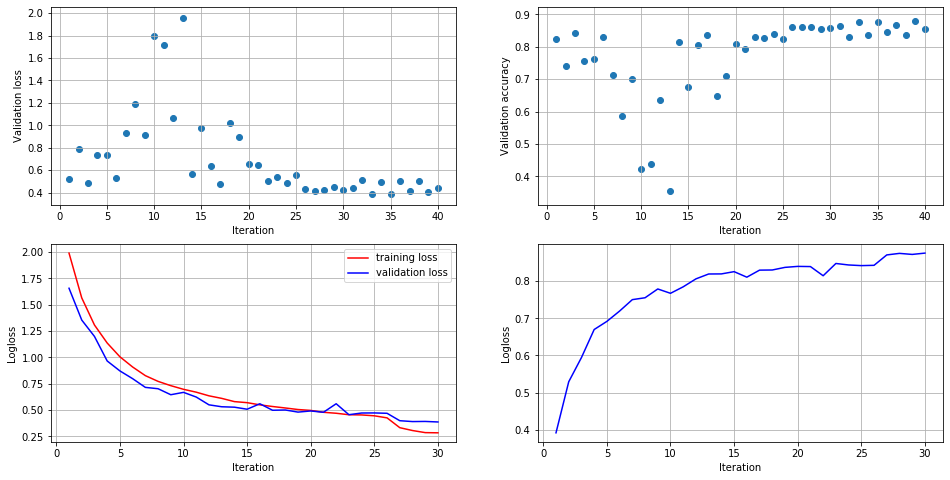

In [39]:
fig0, axs = plt.subplots(2, 2, figsize=(16, 8))

plt.sca(axs[0, 0])
plt.scatter(1 + np.arange(len(trls)), [x['result']['loss'] for x in trls.trials])
plt.xlabel('Iteration')
plt.ylabel('Validation loss')
plt.gca().grid(True)

plt.sca(axs[0, 1])
plt.scatter(1 + np.arange(len(trls)), [max(x['result']['tr_hist'][2]) for x in trls.trials])
plt.xlabel('Iteration')
plt.ylabel('Validation accuracy')
plt.gca().grid(True)

plt.sca(axs[1, 0])
plt.plot(1 + np.arange(len(trls.best_trial['result']['tr_hist'][0])), 
         trls.best_trial['result']['tr_hist'][0], 
         color='red', label='training loss')
plt.plot(1 + np.arange(len(trls.best_trial['result']['tr_hist'][0])), 
         trls.best_trial['result']['tr_hist'][1], 
         color='blue', label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.gca().grid(True)
plt.legend()

plt.sca(axs[1, 1])
plt.plot(1 + np.arange(len(trls.best_trial['result']['tr_hist'][0])), 
         trls.best_trial['result']['tr_hist'][2], 
         color='blue')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.gca().grid(True)

In [48]:
best_pars = space_eval(hp_torch4, 
    {k: v[0] for (k, v) in trls.best_trial['misc']['vals'].items() if len(v) > 0})
best_pars

{'learning': {'lr_sch': {'pars': {'factor': 0.4, 'patience': 2},
   'type': 'plateau'},
  'opt': {'lr': 0.0006256486680466045, 'weight_decay': 0.0005523178665175998}},
 'model': {'downsampling': 'avgpool',
  'drop_conv': 0.2,
  'drop_linear': None,
  'hid_channels_mult': 1.0,
  'out_channels_mult': 2.0,
  'res_blocks': 3,
  'res_kernel': 5,
  'start_channels': 32}}

## Training best model

In [49]:
model = TinyResNet(**best_pars['model'])
model.type(torch.cuda.FloatTensor)
model.to(GPU)

TinyResNet(
  (conv0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (resblock1): Sequential(
    (0): Bottleneck(
      (convblock): Sequential(
        (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
        (6): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (walkaround): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1)

In [51]:
loss_fct = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), **best_pars['learning']['opt'])
    
if best_pars['learning']['lr_sch']['type'] == 'step_lr':
    lr_sch = torch.optim.lr_scheduler.StepLR(opt, 
        **best_pars['learning']['lr_sch']['pars'])
elif best_pars['learning']['lr_sch']['type'] == 'cosine':
    lr_sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 
        **best_pars['learning']['lr_sch']['pars'])
elif best_pars['learning']['lr_sch']['type'] == 'plateau':
    lr_sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 
        **best_pars['learning']['lr_sch']['pars'])
    
lr_plateau = best_pars['learning']['lr_sch']['type'] == 'plateau'

In [ ]:
tr_res = train_torch(model, GPU, train_loader_aug, val_loader_aug, 
                     loss_fct, opt, lr_sch, accuracy, 
                     num_epochs=50, verbose=True, show_progress=True, 
                     early_stopping=True, early_stopping_rounds=8, 
                     lr_plateau=(hps['learning']['lr_sch']['type'] == 'plateau'), 
                     delay=0)